# Evaluation for the CatBoost

After modeling, we raise the question where our models tend to systematic errors. This might help us to further improve our model (e.g., by Feature Engineering).

Especially interesting are systematic errors between "False Positive" and "True Negative" on one hand, and "False Negative" and "True Positive" on the other.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from myfunctions import plot_categorical_features

import warnings
warnings.filterwarnings("ignore")

In [3]:
# read the dataframes with prediction outcome from last notebook 
df_train_eval = pd.read_pickle('./data/eval/df_train_eval_catboost.pkl')
df_test_eval = pd.read_pickle('./data/eval/df_test_eval_catboost.pkl')

In [4]:
# create a column that contains the classification outcome

def classification_evaluation(row):
    '''input: row of a dataframe
    output: classification outcome based on y_pred'''
    if row['churn_risk_score'] == 1 and row['y_pred'] == 1:
        return 'TruePositive'
    elif row['churn_risk_score'] == 0 and row['y_pred'] == 0:
        return 'TrueNegative'
    elif row['churn_risk_score'] == 1 and row['y_pred'] == 0:
        return 'FalseNegative'
    elif row['churn_risk_score'] == 0 and row['y_pred'] == 1:
        return 'FalsePositive'

df_test_eval['classification_outcomes'] = df_test_eval.apply(classification_evaluation, axis=1)


In [5]:
df_test_eval.head(20)

age gender region_category  membership_category  \
32930   35      F            City        No Membership   
12650   10      F            City     Basic Membership   
35289   50      M            Town  Platinum Membership   
35730   32      M         Unknown    Silver Membership   
14788   18      F         Unknown  Platinum Membership   
29267   28      M         Unknown        No Membership   
24718   18      F            City     Basic Membership   
19896   26      F            Town        No Membership   
31448   10      F            Town     Basic Membership   
17300   39      M            City        No Membership   
6307    52      M            Town        No Membership   
28196   61      M            City  Platinum Membership   
26242   36      F            Town    Silver Membership   
9002    59      M            Town        No Membership   
2939    27      F         Unknown        No Membership   
2660    36      F            Town    Silver Membership   
5328    48      M            City      Gold Membership   
287     62      F            Town     Basic Membership   
1263    62      F            Town      Gold Membership   
35436   34      F            Town     Basic Membership   

      joined_through_referral     preferred_offer_types medium_of_operation  \
32930                 Unknown  Credit/Debit Card Offers          Smartphone   
12650                     Yes  Credit/Debit Card Offers          Smartphone   
35289                      No            Without Offers             Desktop   
35730                     Yes  Credit/Debit Card Offers                Both   
14788                      No  Credit/Debit Card Offers             Desktop   
29267                      No     Gift Vouchers/Coupons          Smartphone   
24718                     Yes     Gift Vouchers/Coupons          Smartphone   
19896                      No     Gift Vouchers/Coupons                   ?   
31448                 Unknown            Without Offers             Desktop   
17300                 Unknown     Gift Vouchers/Coupons             Desktop   
6307                       No     Gift Vouchers/Coupons             Desktop   
28196                     Yes  Credit/Debit Card Offers             Desktop   
26242                      No            Without Offers             Desktop   
9002                      Yes            Without Offers             Desktop   
2939                      Yes            Without Offers                   ?   
2660                       No     Gift Vouchers/Coupons          Smartphone   
5328                       No            Without Offers             Desktop   
287                        No  Credit/Debit Card Offers             Desktop   
1263                      Yes            Without Offers          Smartphone   
35436                      No  Credit/Debit Card Offers                   ?   

      internet_option  days_since_last_login  avg_time_spent  ...  \
32930     Fiber_Optic                      5      535.730000  ...   
12650     Mobile_Data                     20       34.390000  ...   
35289     Mobile_Data                      9      291.300000  ...   
35730     Mobile_Data                      6      580.270000  ...   
14788           Wi-Fi                      8       31.620000  ...   
29267           Wi-Fi                     13      158.310000  ...   
24718     Fiber_Optic                     23      111.650000  ...   
19896     Mobile_Data                     22      226.920000  ...   
31448     Fiber_Optic                     13     -810.565055  ...   
17300     Fiber_Optic                      6      148.400000  ...   
6307      Mobile_Data                     10      156.700000  ...   
28196           Wi-Fi                      7       55.140000  ...   
26242           Wi-Fi                     14      139.590000  ...   
9002            Wi-Fi                      8       85.340000  ...   
2939      Mobile_Data                     17      820.580000  ...   
2660      Mobile_Data   

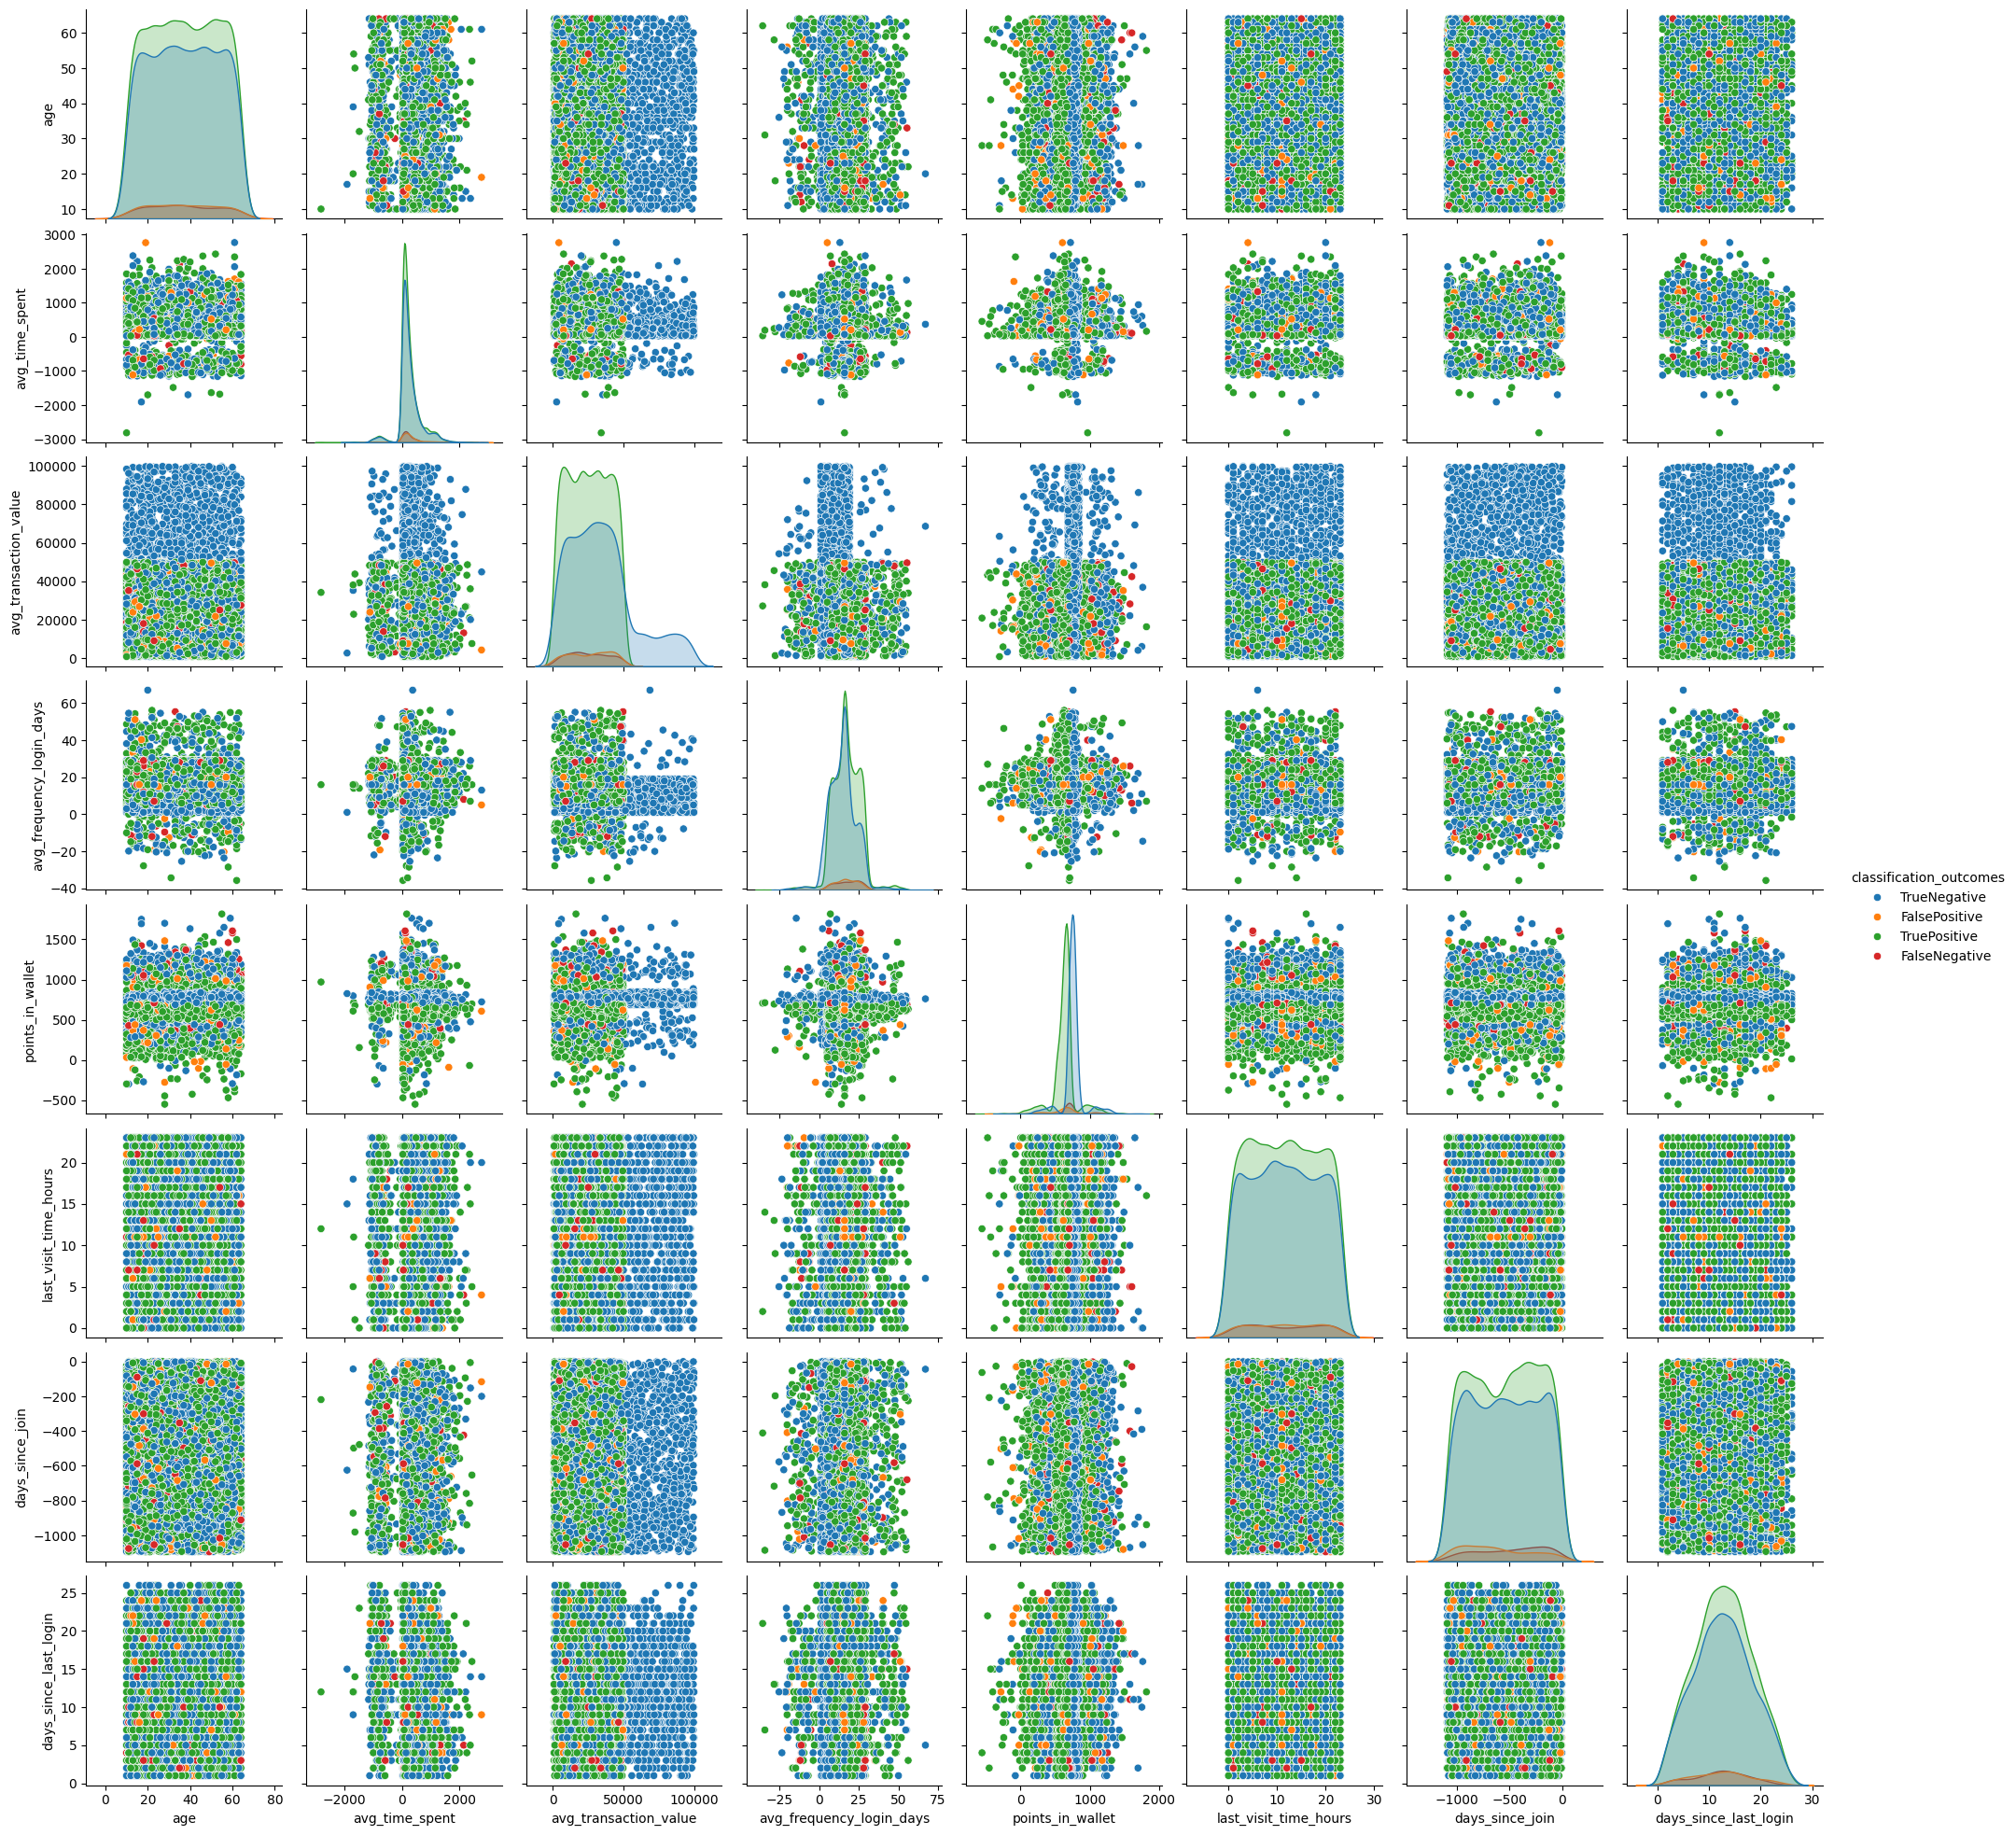

In [6]:
#define numerical features
num_features = ["age", "avg_time_spent", "avg_transaction_value", "avg_frequency_login_days", "points_in_wallet", "last_visit_time_hours", "days_since_join", "days_since_last_login","classification_outcomes"]

#set order for legend
hue_order = ["TrueNegative", "FalsePositive", "TruePositive", "FalseNegative"]

#plot pairplot to get a sense for systematic misevaluations
sns.pairplot(df_test_eval[num_features], hue='classification_outcomes', plot_kws=dict(alpha= 1), hue_order= hue_order)

The histograms for the different numerical features show a high overlap for most of the features. Differences may be found for 'avg_transcation_value' and 'points_in_wallet'.

- **avg_transaction_value**:
    - High values can be found for TN
    - TN shows two "populations"
    - other classifications outcomes and the majority of TN is within the first "population"
- **points_in_wallet**:
    - high values for TN, low values for TP, while FN and FP seem to be somewhere in between

Due to the high number of datapoints many values overlap which makes it difficult to get a decent overview of different classification outcomes. Moreover, due to the success of the model, most classification outcomes are either TN or TP. FN and FP are accordingly minority populations. To get a more balanced view, we decided to create a pairplot with balanced populations (all having the same number of data points). For this, we use undersampling based on the classification outcome with the least data points.

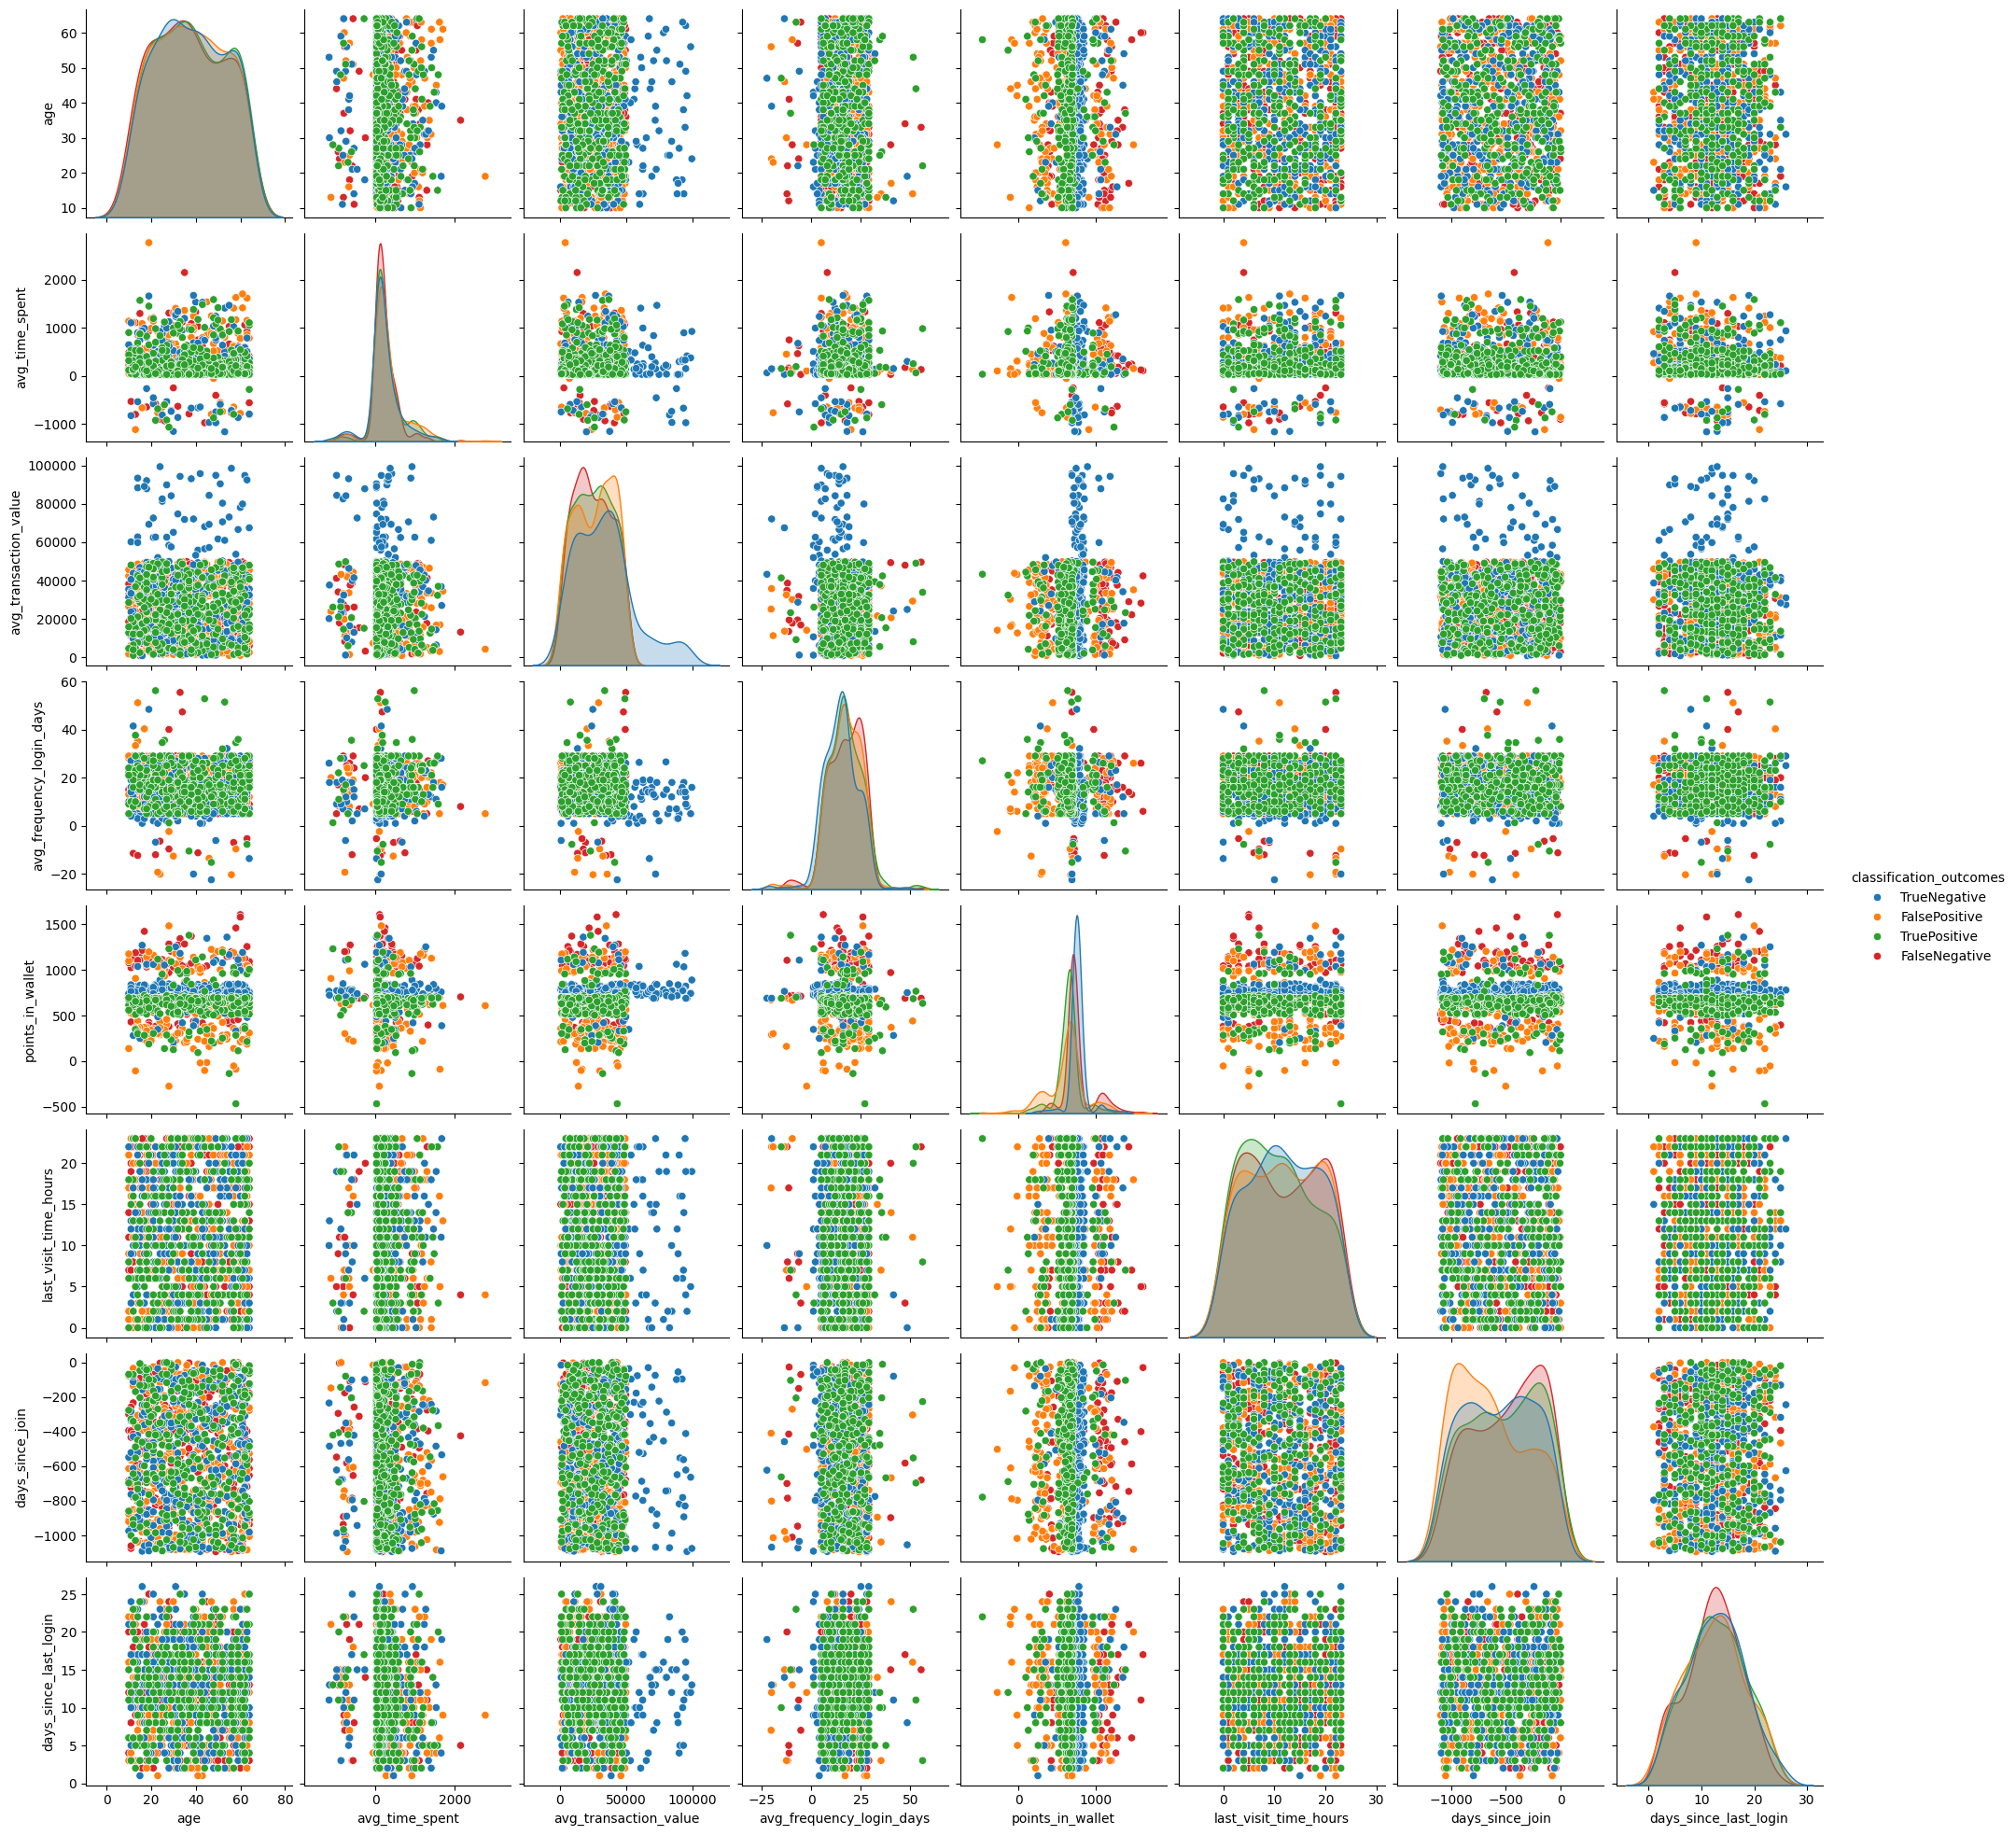

In [8]:
# Count the occurrences of each category
category_counts = df_test_eval['classification_outcomes'].value_counts()

# Set a sample size relatively to the count of the smallest category
sample_size = np.round(category_counts.min())

# Group the DataFrame by the category
grouped = df_test_eval.groupby('classification_outcomes')

# Sample each group to get a balanced DataFrame
balanced_df = grouped.apply(lambda x: x.sample(sample_size))

# Reset index of the resulting DataFrame
balanced_df = balanced_df.reset_index(drop=True)

#plot balanced df as pairplot
#take some hue_order as for the full dataset
sns.pairplot(balanced_df[num_features], hue='classification_outcomes', plot_kws=dict(alpha=1), hue_order= hue_order)

This overview indicates that for 'points_in_wallet' high values lead to a negative prediction (and therefore TN and FN), while low values lead to a positive prediction (and therefore TP and FP). 

### Barplot of the classification outcome for each categorical feature

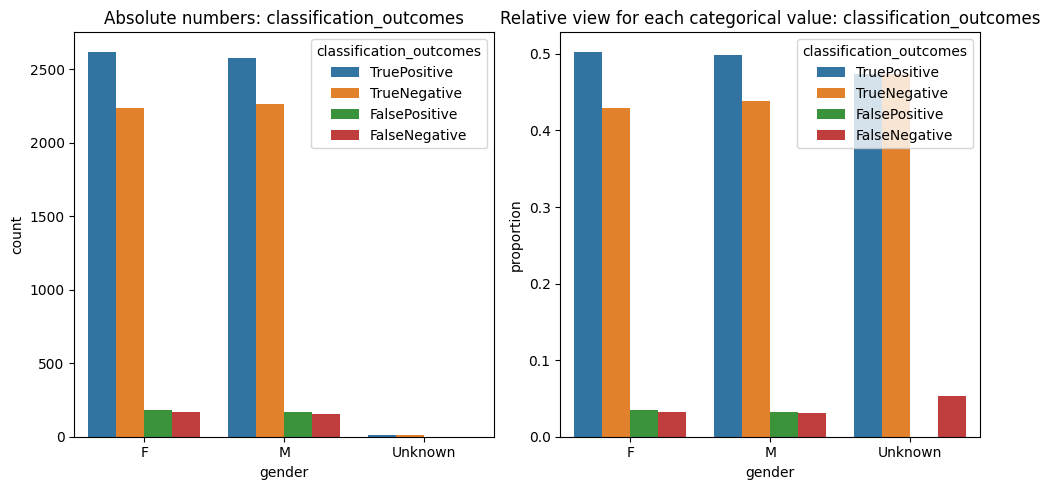

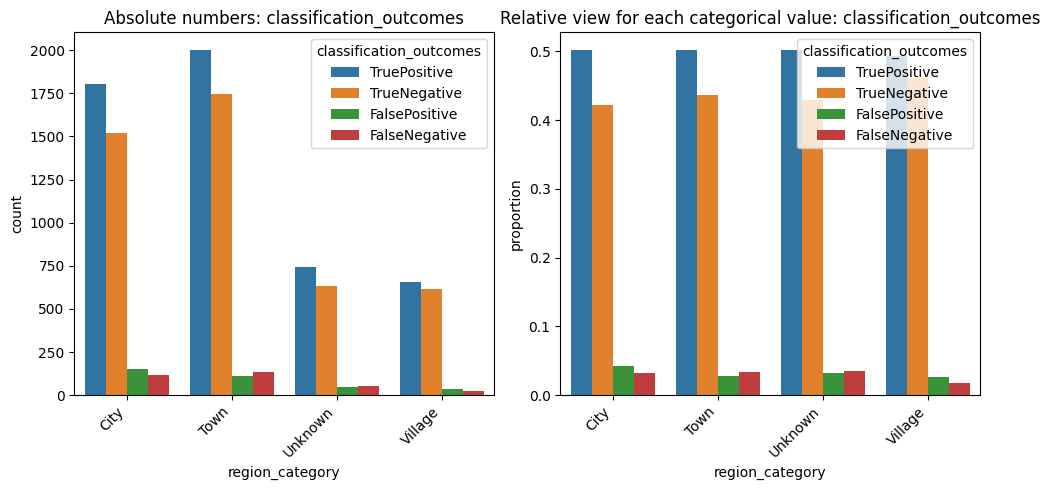

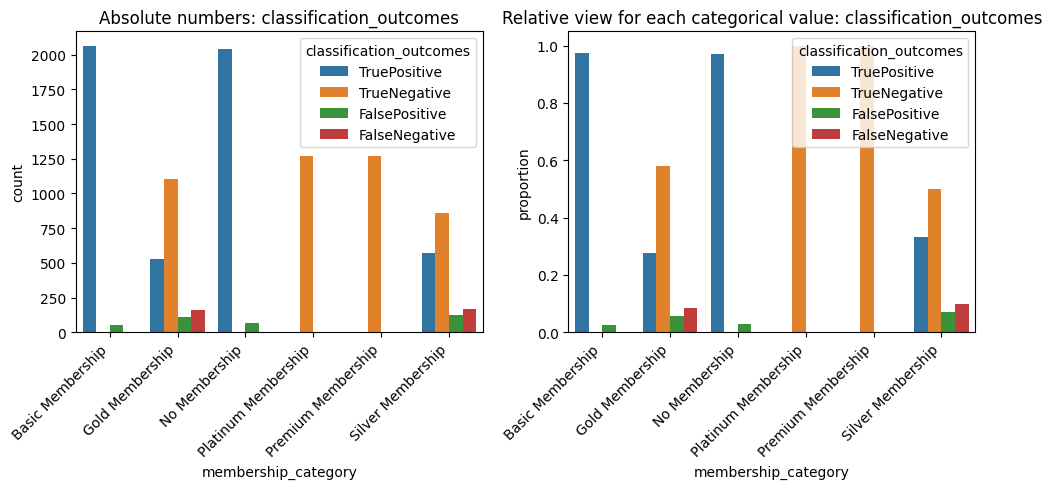

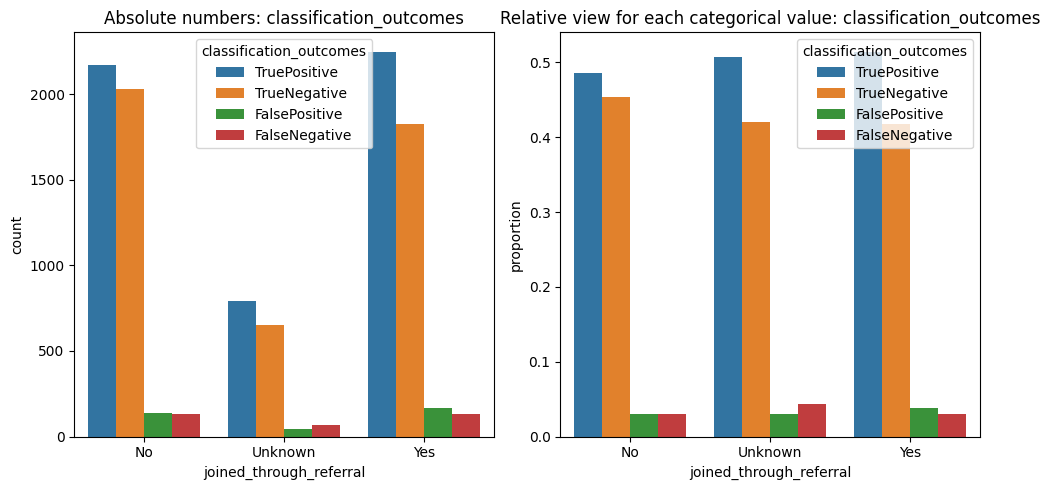

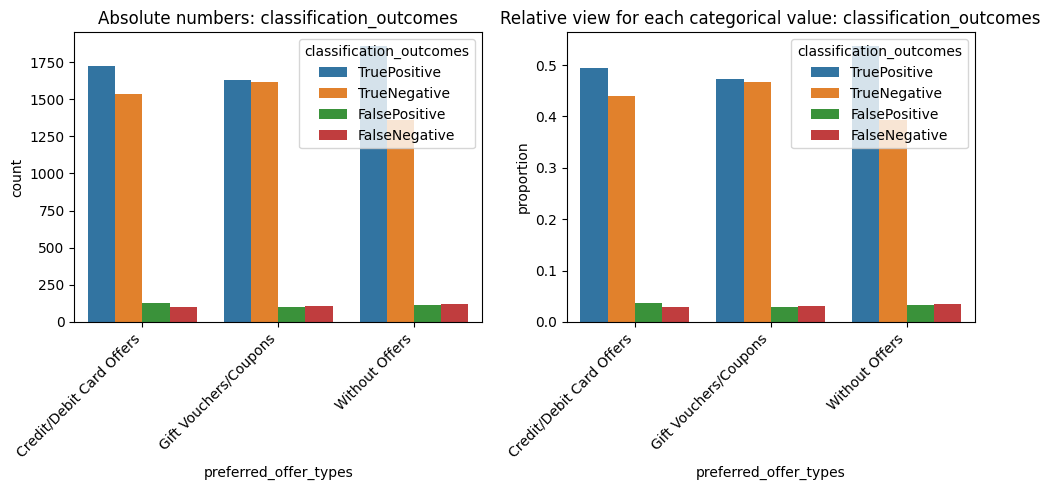

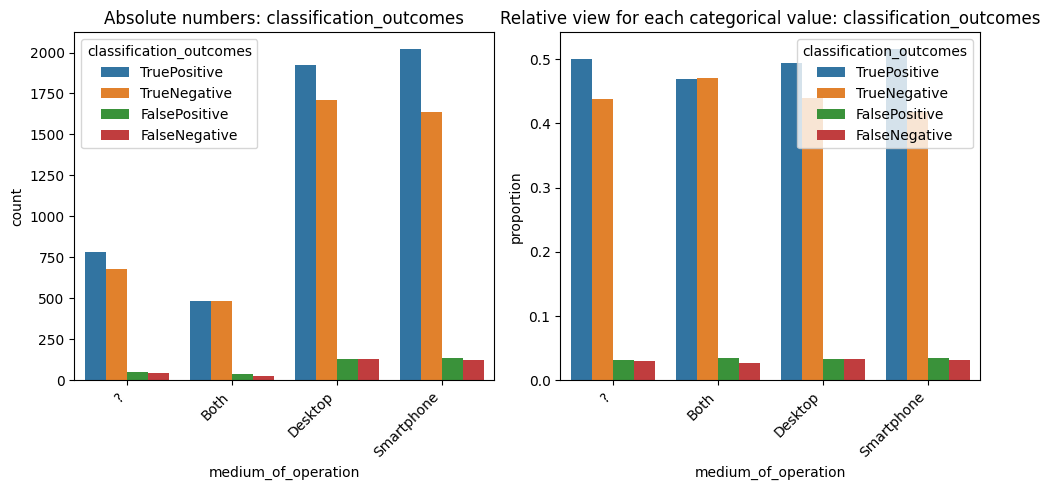

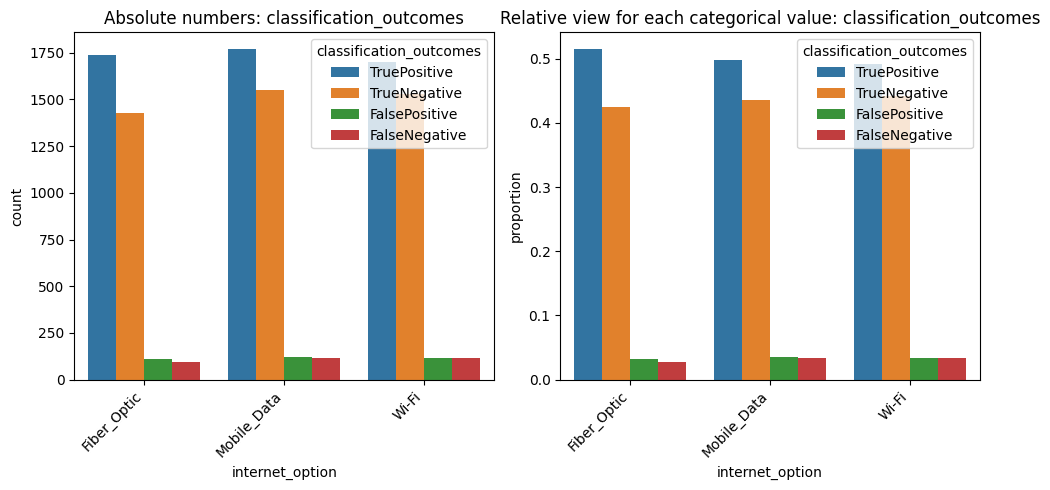

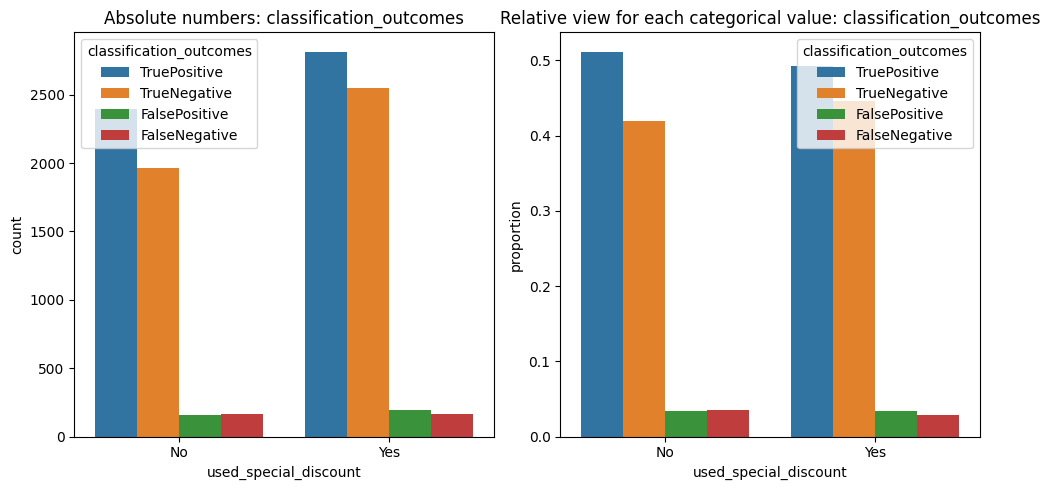

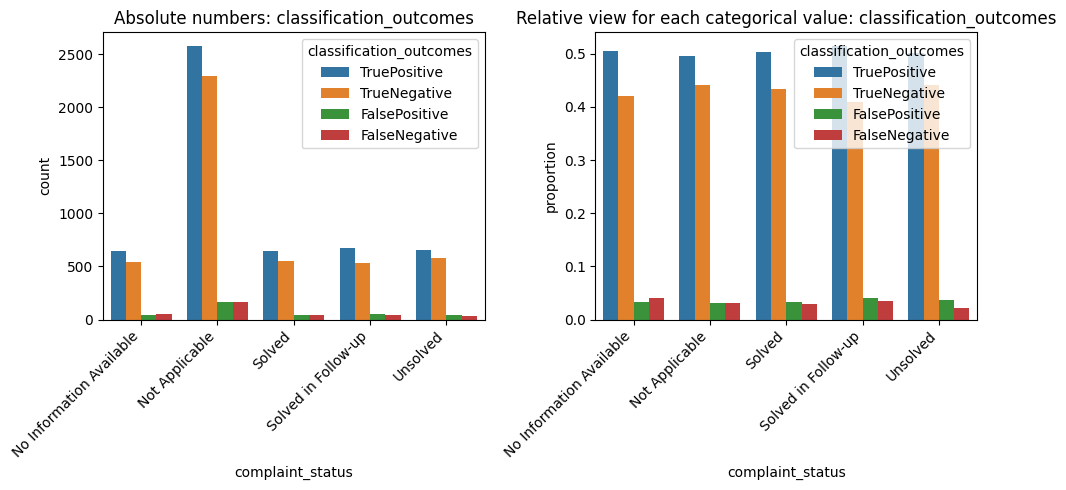

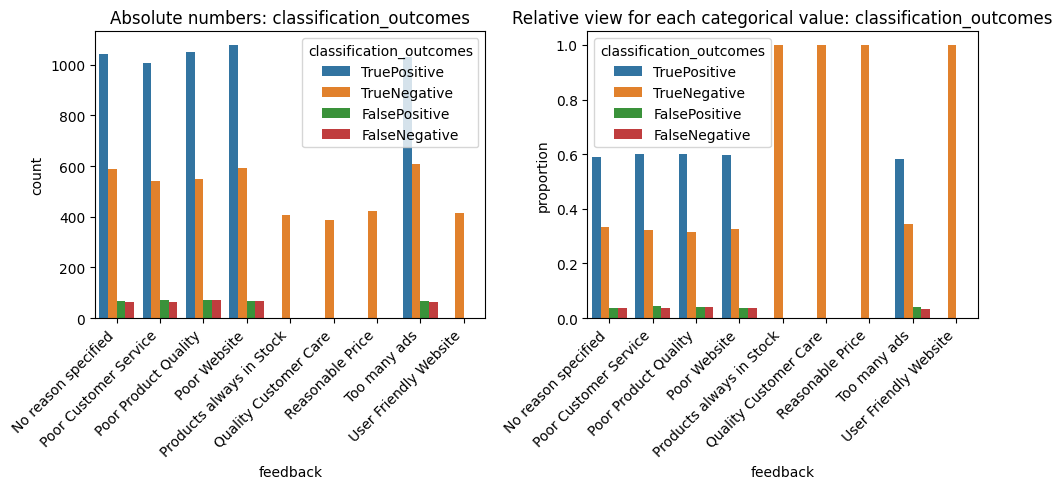

In [9]:
# Drop numerical features, predictions and ground truth ("churn_risk_score") to focus on categorical ones
categorical_features = [col for col in df_test_eval.columns if col not in num_features and col not in ["churn_risk_score", "y_pred"]]
# Plot a absolute an relative barplot of the classification outcome for each categorical feature
plot_categorical_features(df=df_test_eval, features=categorical_features, hue='classification_outcomes')

# Learnings

From the pairplot for numerical features and the barplots for categorical features, we identified the following patterns for correct and incorrect classifications:

1. As expected from high correlation of 'membership_category' and the 'churn_risk_score', there are very few misclassified observations for extreme membership category values ('No Membership', 'Basic Membership, 'Platinum Membership', 'Premium Membership'), while intermediate values ('Silver Membership', 'Gold Membership') show higher percentages of FP and FN.
2. Positive feedback results in a majority of TN. While negative feedback has no clear pattern.
3. High 'avg_transaction_value' increases the chance for a negative prediction (TN and FN alike) and vice versa
4. High 'points_in_wallet' show a similar trend.

These findings are somehow in accordance with the feature importance for the CatBoost model from notebook 05_03 where 'membership_category' has special importance. Also 'points_in_wallet', 'avg_transaction_value' and 'feedback' have some importance. 
